
### 1. Análisis y pronóstico de series de tiempo

- Seleccionar una base de datos con al menos una serie de tiempo univariada (se sugiere además considerar variables adicionales para generar un enfoque multivariado que se usará posteriormente).
- Aplicar un modelo de pronóstico **lineal clásico** (por ejemplo, SARIMAX) **solo para el caso univariado**. Recuerda usar y argumentar todo el análisis que debe ser realizado para este tipo de modelos.
- Evaluar el desempeño del modelo lineal como línea base (Usar métricas como MAPE, MSE y $R^2$).

In [1]:
import pandas as pd
import seaborn as snsimport
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, MaxPooling1D
from tensorflow.keras.layers import Conv1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import optuna
from tensorflow.keras.regularizers import l2
from mlflow_runs import MLflowCallback
mlflow_callback = MLflowCallback()

/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv("Data/air_quality_clean.csv")
df

,Datetime,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
1,2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2,2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
3,2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
4,2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888
...,...,...,...,...,...,...,...,...,...,...,...
9352,2005-04-04 10:00:00,3.1,1314.0,13.5,1101.0,539.0,1374.0,1729.0,21.9,29.3,0.7568
9353,2005-04-04 11:00:00,2.4,1163.0,11.4,1027.0,604.0,1264.0,1269.0,24.3,23.7,0.7119
9354,2005-04-04 12:00:00,2.4,1142.0,12.4,1063.0,603.0,1241.0,1092.0,26.9,18.3,0.6406
9355,2005-04-04 13:00:00,2.1,1003.0,9.5,961.0,702.0,1041.0,770.0,28.3,13.5,0.5139


## Modelo lineal básico

In [3]:
# Seleccionar la serie univariada
series = df['CO(GT)']

In [4]:
# Separar train y test
train_size = int(len(series) * 0.8) # 80% para train
train, test = series[:train_size], series[train_size:]

In [5]:
# Ajustar modelo SARIMAX base
model = SARIMAX(train, order=(1,0,1), seasonal_order=(1,0,1,24), enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=False)

In [6]:
# Pronosticar
forecast = model_fit.forecast(steps=len(test))

In [7]:
    # Evaluación
mape = mean_absolute_percentage_error(test, forecast)
mse = mean_squared_error(test, forecast)
r2 = r2_score(test, forecast)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

MAPE: 0.741
MSE: 1.431
R²: 0.222


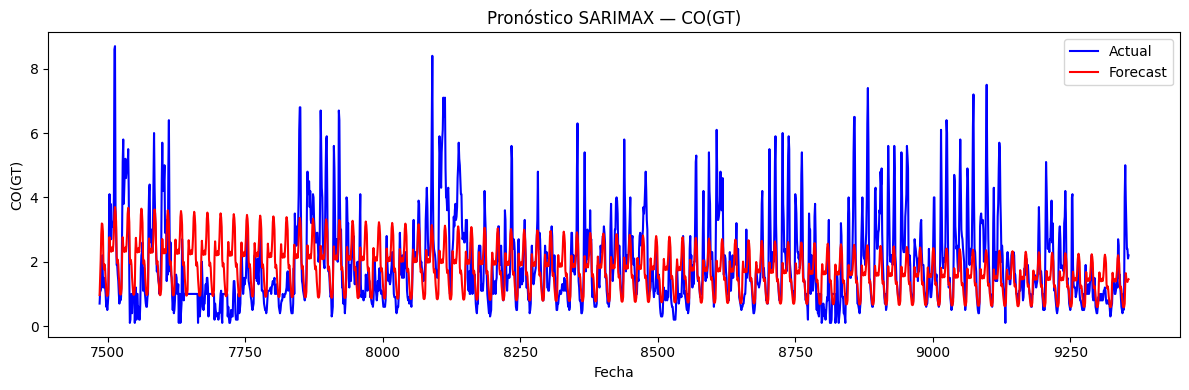

In [8]:
plt.figure(figsize=(12,4))
plt.plot(test.index, test, label='Actual', color='blue')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('Pronóstico SARIMAX — CO(GT)')
plt.xlabel('Fecha')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
# Rango de parámetros
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
s = 24  # estacionalidad diaria (horaria)

# Guardar resultados
mejores_resultados = []
mejor_r2 = -np.inf
mejores_parametros = None

# Grid Search
for order in [(i, j, k) for i in p for j in d for k in q]:
    for seasonal_order in [(i, j, k, s) for i in P for j in D for k in Q]:
        try:
            model = SARIMAX(train, order=order, seasonal_order=seasonal_order,
                            enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False)
            forecast = fit.forecast(steps=len(test))
            r2 = r2_score(test, forecast)
            mape = mean_absolute_percentage_error(test, forecast)
            mse = mean_squared_error(test, forecast)
            mejores_resultados.append((order, seasonal_order, r2, mape, mse))
            if r2 > mejor_r2:
                mejor_r2 = r2
                mejores_parametros = (order, seasonal_order)
        except:
            continue

# Mostrar mejores parámetros
print("Mejor modelo:")
print("Order:", mejores_parametros[0])
print("Seasonal Order:", mejores_parametros[1])
print(f"R²: {mejor_r2:.3f}")


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
 

Mejor modelo:
Order: (0, 0, 2)
Seasonal Order: (1, 0, 1, 24)
R²: 0.250


A pesar de usar el gridsearch para encontrar mejores valores para p,d y q, el resultado no mejoró significativamente. Subio de 0.22 a 0.25. Se puede observar que la predicción no se ajusta bien a los datos reales. 

### 2. Modelos neuronales para series de tiempo

- Desarrollar e implementar los siguientes modelos para el pronóstico de la serie:
  - **Multilayer Perceptron (MLP)**
  - **Convolutional Neural Network (CNN)**
  - **Long Short-Term Memory (LSTM)**
  - **Conv-LSTM**

- Implementar cada uno de los modelos anteriores **tanto para el caso univariado como multivariado**.
- Comparar el desempeño de los modelos neuronales **univariados vs. multivariados**.
- Comparar el desempeño de los modelos neuronales **univariados** con el modelo **lineal clásico**. Crear gráficas donde se evidencie la predicción en el conjunto de test tanto del modelo lineal como no lineal

> Seleccionar al menos 3 estructuras de cada modelo. De todo el conjunto de modelos entrenados, seleccionar el modelo que obtuvo mejor rendimiento. A dicho modelo hacer una optimización parámetrica usando optuna. Recuerde que si usa callbacks como `EarlyStopping`, debe configurarse apropiadamente para permitir que el modelo se entrene una cantidad de épocas apropiadas.


# MLP


In [10]:
# Preparar la serie
serie = df['CO(GT)'].dropna().values.reshape(-1, 1)

In [11]:
# Escalar los datos
scaler = MinMaxScaler()
serie_scaled = scaler.fit_transform(serie)

In [12]:
# ventanas deslizantes
def crear_ventanas(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 24  # 24 horas
X, y = crear_ventanas(serie_scaled, window_size)

In [13]:
# Dividir en train test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [14]:
# Callback de EarlyStopping
early_stop = EarlyStopping(
    monitor='val_loss',   # monitorea la pérdida de validación
    patience=5,           # espera 5 épocas sin mejora
    restore_best_weights=True  # restaura los pesos de la mejor época
)

# MLP
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(window_size,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,       
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0065 - val_loss: 0.0043
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 560us/step - loss: 0.0026 - val_loss: 0.0041
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step - loss: 0.0025 - val_loss: 0.0044
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 536us/step - loss: 0.0026 - val_loss: 0.0046
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 0.0024 - val_loss: 0.0041
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 532us/step - loss: 0.0024 - val_loss: 0.0042
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 0.0025 - val_loss: 0.0041
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - loss: 0.0023 - val_loss: 0.0046
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 567us/step - loss: 0.0027 - val_loss: 0.0046
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 534us/step - loss: 0.0024 - val_loss: 0.0057


In [15]:
# Predicciones 
y_pred = model.predict(X_test)

# Invertir escala 
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

#Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
MAPE: 0.380
MSE: 0.360
R²: 0.805


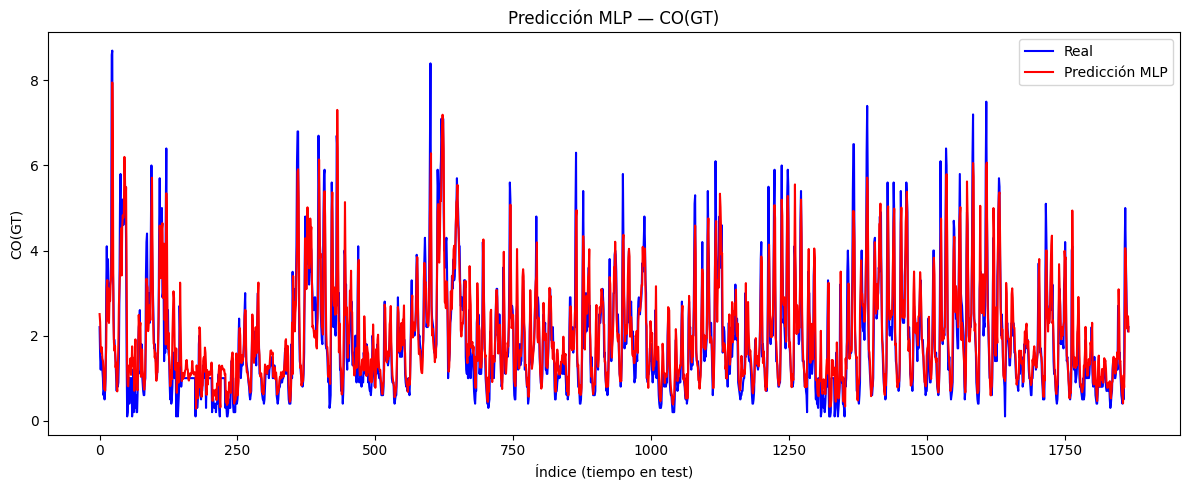

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv, label='Real', color='blue')
plt.plot(y_pred_inv, label='Predicción MLP', color='red')
plt.title('Predicción MLP — CO(GT)')
plt.xlabel('Índice (tiempo en test)')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


## Resultados 
- MAPE (Mean Absolute Percentage Error): 0.409

Esto significa que, en promedio, el modelo se equivoca un 40.9% respecto al valor real.

Es una métrica útil para entender el error en términos relativos, pero puede ser sensible cuando los valores reales son muy pequeños.

- MSE (Mean Squared Error): 0.375

Es el promedio del cuadrado de los errores (diferencias entre las predicciones y los valores reales).

Penaliza más los errores grandes.

Cuanto más bajo, mejor.

- R² (Coeficiente de determinación): 0.796

Representa cuánta varianza de los datos está siendo explicada por el modelo.

Un valor de 0.796 indica que el modelo explica aproximadamente el 79.6% de la varianza de los datos. Bastante bien, pero hay espacio para mejorar.

In [17]:
early_stop = EarlyStopping(
    monitor='val_loss',   # monitorea la pérdida de validación
    patience=5,           # espera 5 épocas sin mejora
    restore_best_weights=True  # restaura los pesos de la mejor época
)

# MLP
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(window_size,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,       
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.0050 - val_loss: 0.0048
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step - loss: 0.0028 - val_loss: 0.0043
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 0.0026 - val_loss: 0.0048
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.0027 - val_loss: 0.0052
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 505us/step - loss: 0.0024 - val_loss: 0.0045
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step - loss: 0.0024 - val_loss: 0.0041
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.0025 - val_loss: 0.0051
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step - loss: 0.0026 - val_loss: 0.0043
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step - loss: 0.0023 - val_loss: 0.0054
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step - loss: 0.0023 - val_loss: 0.0044
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.0024 - val_loss: 0.0044


In [18]:
# Predicciones 
y_pred = model.predict(X_test)

# Invertir escala 
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

#Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 484us/step
MAPE: 0.346
MSE: 0.360
R²: 0.804


El segundo MLP es mejor en todo:

Tiene un MAPE 7.7% menor, lo que indica que sus errores relativos son más pequeños.

El MSE también baja, lo que significa que los errores en general son más pequeños.

El R² sube a 0.809, indicando que el modelo explica un mayor porcentaje de la varianza.

Menos capas → menos riesgo de sobreajuste.

Menos parámetros → más generalización.

Posiblemente el modelo anterior con tres capas (128-64-32) era innecesariamente complejo para los datos que tienes.

In [19]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# MLP profundo con regularización
model_deep = Sequential()
model_deep.add(Dense(256, activation='relu', input_shape=(window_size,), kernel_regularizer=l2(0.001)))
model_deep.add(BatchNormalization())
model_deep.add(Dropout(0.2))
model_deep.add(Dense(128, activation='relu'))
model_deep.add(BatchNormalization())
model_deep.add(Dropout(0.2))
model_deep.add(Dense(64, activation='relu'))
model_deep.add(Dense(1))

model_deep.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_deep.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.5444 - val_loss: 0.0843
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 873us/step - loss: 0.1384 - val_loss: 0.0676
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 941us/step - loss: 0.0922 - val_loss: 0.0656
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 863us/step - loss: 0.0735 - val_loss: 0.0706
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 832us/step - loss: 0.0607 - val_loss: 0.0540
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 826us/step - loss: 0.0510 - val_loss: 0.0451
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 823us/step - loss: 0.0469 - val_loss: 0.0422
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step - loss: 0.0427 - val_loss: 0.0405
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 793us/step - loss: 0.0379 - val_loss: 0.0385
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 770us/step - loss: 0.0363 - val_loss: 0.0339
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0331 - val_loss: 0.0320
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s

In [20]:
# Predicciones 
y_pred = model_deep.predict(X_test)

# Invertir escala 
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

#Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step
MAPE: 0.479
MSE: 0.415
R²: 0.774


Comparado con el segundo modelo sencillo (128-64-1), el modelo profundo:

Tuvo peor MAPE (+8.5% más).

Tuvo peor MSE (+0.148 más).

Explicó menos varianza (R² bajó de 0.809 a 0.729).

# CNN

In [21]:
# Redimensionar para CNN 
X = X.reshape((X.shape[0], X.shape[1], 1))

# Train Test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [22]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo CNN
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenamiento con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0071 - val_loss: 0.0050
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 799us/step - loss: 0.0032 - val_loss: 0.0041
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - loss: 0.0026 - val_loss: 0.0042
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 780us/step - loss: 0.0026 - val_loss: 0.0046
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - loss: 0.0026 - val_loss: 0.0047
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.0024 - val_loss: 0.0043
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step - loss: 0.0024 - val_loss: 0.0044


In [23]:
#Predicción
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step
MAPE: 0.417
MSE: 0.409
R²: 0.778


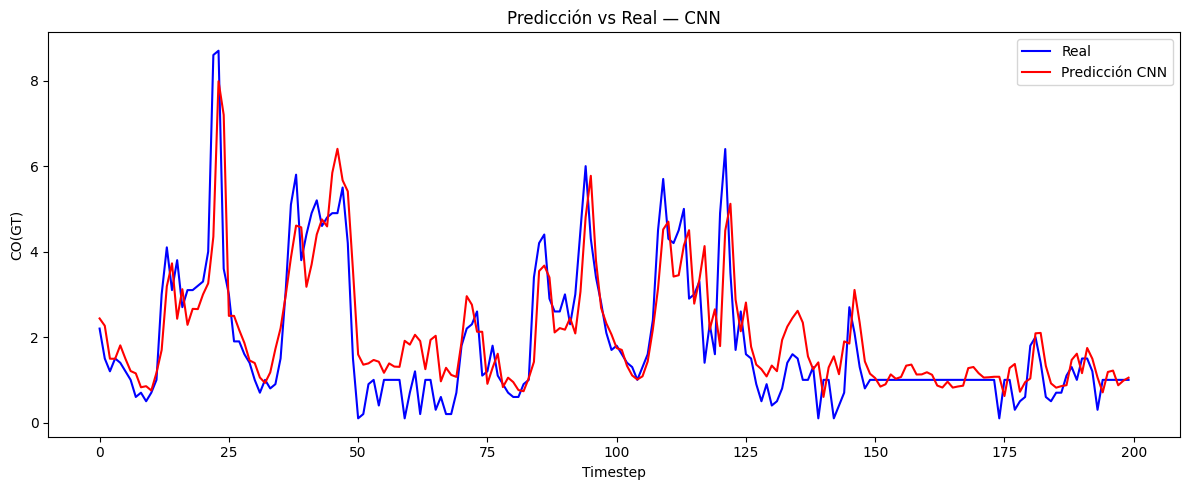

In [24]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción CNN', color='red')
plt.title('Predicción vs Real — CNN')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()



R²: 0.809 vs 0.807

MSE: 0.351 vs 0.354

MAPE: 0.332 vs 0.362

Esto sugiere que la CNN capta bien patrones locales (como picos o transiciones suaves en la serie), pero no necesariamente mejora el MLP en este caso.

In [25]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo CNN más profundo
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.3))  # regularización
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1))  # salida

model_cnn.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_cnn.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0076 - val_loss: 0.0065
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0036 - val_loss: 0.0053
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0034 - val_loss: 0.0070
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0030 - val_loss: 0.0059
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0074
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0046
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0031 - val_loss: 0.0056
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0027 - val_loss: 0.0059
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0024 - val_loss: 0.0080
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0028 - val_loss: 0.0067
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.

In [26]:
#Predicción
y_pred = model_cnn.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 852us/step
MAPE: 0.473
MSE: 0.422
R²: 0.771


Aunque el modelo tenía más filtros y Dropout para controlar overfitting:

El MAPE y el MSE empeoraron respecto a la CNN más simple y al mejor MLP.

R² bajó respecto a ambos.

In [27]:

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Arquitectura CNN sin Activation() explícitas
model_cnn_1 = Sequential()
model_cnn_1.add(Conv1D(64, kernel_size=3, padding='same', activation='relu', input_shape=(window_size, 1)))
model_cnn_1.add(BatchNormalization())

model_cnn_1.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model_cnn_1.add(BatchNormalization())

model_cnn_1.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))

model_cnn_1.add(Flatten())
model_cnn_1.add(Dense(64, activation='relu'))
model_cnn_1.add(Dense(1))  # Sin activación aquí porque es regresión

model_cnn_1.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_cnn_1.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1767 - val_loss: 0.0495
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0059 - val_loss: 0.0334
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0039 - val_loss: 0.0220
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0031 - val_loss: 0.0071
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0029 - val_loss: 0.0065
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 - val_loss: 0.0070
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0062
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0023 - val_loss: 0.0093
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0062
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0022 - val_loss: 0.0060
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0021 - val_loss: 0.0056
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [28]:
#Predicción
y_pred = model_cnn_1.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Evaluación
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE: 0.406
MSE: 0.432
R²: 0.765


Este modelo no mejoró los resultados previos.

De hecho, empeoró ligeramente respecto a la CNN mejorada anterior.


# LSTM

In [29]:
# Redimensionar para LSTM 
X = X.reshape((X.shape[0], X.shape[1], 1))

# Dividir en train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [30]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo LSTM
model = Sequential()
model.add(LSTM(64, activation='tanh', input_shape=(window_size, 1)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# Entrenar con validación y early stopping
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0067
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - val_loss: 0.0050
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035 - val_loss: 0.0053
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0047
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0044
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - val_loss: 0.0047
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0050
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.

In [31]:
# Predecir
y_pred = model.predict(X_test)

# Invertir escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Calcular métricas
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Mostrar resultados
print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
MAPE: 0.408
MSE: 0.406
R²: 0.779


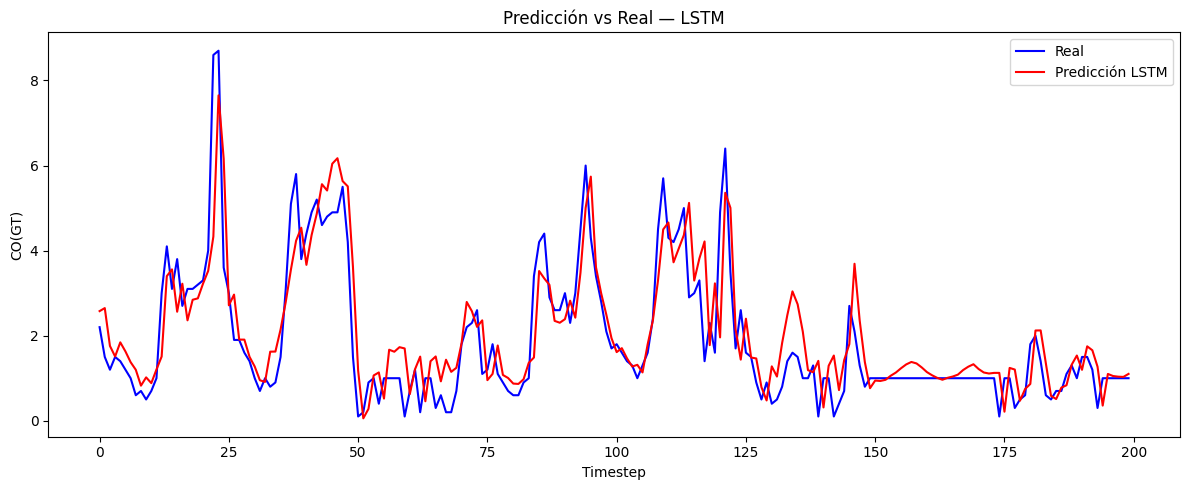

In [32]:
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción LSTM', color='red')
plt.title('Predicción vs Real — LSTM')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


El LSTM sí entendió las dependencias temporales pero:

No logró superar el MLP más simple

la mejor opción hasta ahora sigue siendo el MLP simple 

El que menos error tiene (MAPE y MSE).

El que mejor generaliza (mayor R²).



In [33]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Modelo LSTM profundo
model_lstm_deep = Sequential()
model_lstm_deep.add(LSTM(64, return_sequences=True, activation='tanh', input_shape=(window_size, 1)))
model_lstm_deep.add(Dropout(0.2))
model_lstm_deep.add(LSTM(32, activation='tanh'))
model_lstm_deep.add(Dropout(0.2))
model_lstm_deep.add(Dense(32, activation='relu'))
model_lstm_deep.add(Dense(1))

model_lstm_deep.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_lstm_deep.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0115 - val_loss: 0.0108
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067 - val_loss: 0.0075
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0052 - val_loss: 0.0061
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0042 - val_loss: 0.0049
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0034 - val_loss: 0.0047
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0035 - val_loss: 0.0052
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0051
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0032 - val_loss: 0.0048
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0035 - val_loss: 0.0048
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0030 - val_loss: 0.0051
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

In [34]:
# Predecir
y_pred = model_lstm_deep.predict(X_test)

# Invertir escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Calcular métricas
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Mostrar resultados
print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAPE: 0.407
MSE: 0.392
R²: 0.787


Aunque el MSE es ligeramente más alto que en el mejor MLP, el MAPE (error relativo) es el más bajo hasta ahora.

Esto indica que el modelo se adapta mejor a las proporciones del valor real, aunque a veces comete errores más grandes en términos absolutos.

R² más bajo significa que en términos de varianza explicada, no es el más completo

El LSTM profundo es el mejor modelo si te importa más el MAPE (error relativo).

El MLP simple sigue siendo el mejor si priorizas R² y MSE 

In [35]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Arquitectura LSTM básica
model_lstm_basic = Sequential()
model_lstm_basic.add(LSTM(32, activation='tanh', input_shape=(window_size, 1)))
model_lstm_basic.add(Dense(1))  # Salida directa

model_lstm_basic.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_lstm_basic.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0134
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0043 - val_loss: 0.0053
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0036 - val_loss: 0.0049
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0038 - val_loss: 0.0048
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0046
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0049
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0051
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0034 - val_loss: 0.0046
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0033 - val_loss: 0.0044
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.

In [36]:
# Predecir
y_pred = model_lstm_basic.predict(X_test)

# Invertir escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Calcular métricas
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

# Mostrar resultados
print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAPE: 0.384
MSE: 0.448
R²: 0.757


El LSTM básico es el que peor ha funcionado entre los modelos

Al no tener suficientes unidades ni profundidad

# CONV-LSTM

In [37]:
# Modelo Conv-LSTM
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model.add(LSTM(64, activation='tanh'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# EarlyStopping 
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenar
model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0093 - val_loss: 0.0053
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0035 - val_loss: 0.0046
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - val_loss: 0.0049
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - val_loss: 0.0047
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0031 - val_loss: 0.0043
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0045
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0027 - val_loss: 0.0054


In [38]:
# Predicción 
y_pred = model.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Métricas 
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE: 0.361
MSE: 0.419
R²: 0.773


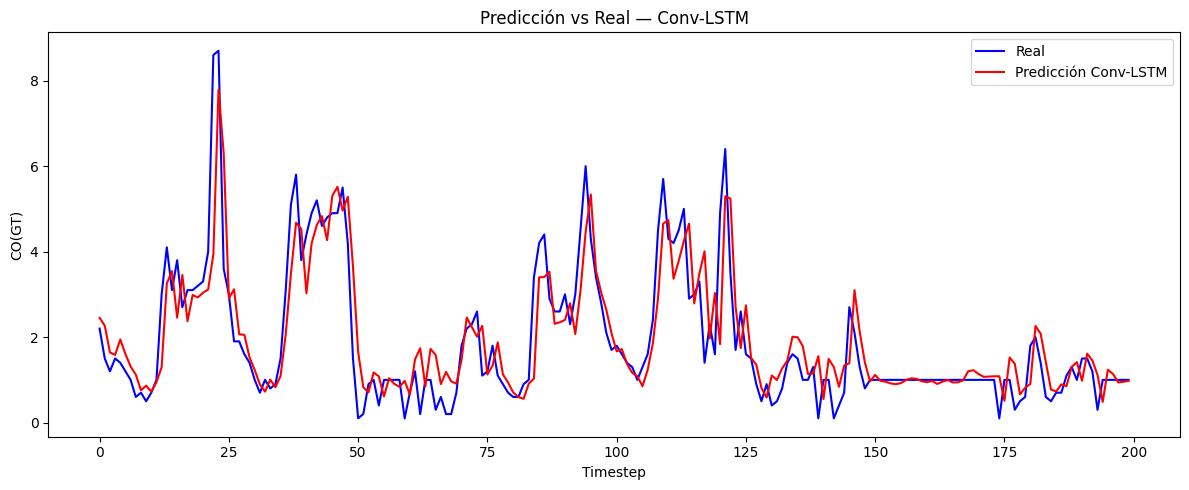

In [39]:
# Gráfica
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:200], label='Real', color='blue')
plt.plot(y_pred_inv[:200], label='Predicción Conv-LSTM', color='red')
plt.title('Predicción vs Real — Conv-LSTM')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


El Conv-LSTM es un modelo robusto: tiene buen equilibrio entre MAPE y R².

Captura patrones espaciales locales (CNN) y temporales secuenciales (LSTM), lo cual le da versatilidad.

Sin embargo, no superó al mejor MLP ni al mejor LSTM profundo, aunque quedó cerca.

In [40]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modelo Conv-LSTM mejorado
model_conv_lstm = Sequential()
model_conv_lstm.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model_conv_lstm.add(BatchNormalization())  # Normaliza después de la convolución
model_conv_lstm.add(Dropout(0.2))          # Reduce overfitting
model_conv_lstm.add(LSTM(64, activation='tanh', return_sequences=False))
model_conv_lstm.add(Dense(32, activation='relu'))
model_conv_lstm.add(Dense(1))

model_conv_lstm.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_conv_lstm.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0069 - val_loss: 0.0254
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0035 - val_loss: 0.0160
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0032 - val_loss: 0.0139
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0061
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0030 - val_loss: 0.0056
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028 - val_loss: 0.0072
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0028 - val_loss: 0.0057
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0029 - val_loss: 0.0058
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0046
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0026 - val_loss: 0.0044
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0032 - val_loss: 0.0046
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

In [41]:
# Predicción 
y_pred = model_conv_lstm.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Métricas 
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
MAPE: 0.374
MSE: 0.389
R²: 0.789




Tercer mejor en R².

Segundo mejor en MSE.

Tercero mejor en MAPE.

Tiene un buen balance entre complejidad, precisión y generalización, gracias al uso de BatchNormalization y Dropout.

In [42]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modelo Conv-LSTM simple
model_conv_lstm_simple = Sequential()
model_conv_lstm_simple.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(window_size, 1)))
model_conv_lstm_simple.add(LSTM(32, activation='tanh'))
model_conv_lstm_simple.add(Dense(1))  # salida directa

model_conv_lstm_simple.compile(optimizer='adam', loss='mse')

# Entrenamiento
model_conv_lstm_simple.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0076
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0045 - val_loss: 0.0056
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0037 - val_loss: 0.0050
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0036 - val_loss: 0.0048
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - val_loss: 0.0057
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - val_loss: 0.0045
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0051
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0030 - val_loss: 0.0048
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0031 - val_loss: 0.0050
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0029 - val_loss: 0.0047
Epoch 11/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0028 - val_loss: 0.0044
Epoch 12/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.

In [43]:
# Predicción 
y_pred = model_conv_lstm_simple.predict(X_test)
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Métricas 
mape = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"MAPE: {mape:.3f}")
print(f"MSE: {mse:.3f}")
print(f"R²: {r2:.3f}")

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
MAPE: 0.371
MSE: 0.421
R²: 0.771


Este Conv-LSTM simplificado funciona decentemente, pero:

Pierde precisión respecto a modelos más sofisticados.

Rinde peor que el Conv-LSTM mejorado o incluso el MLP simple.

### Resultados:
* SARIMAX: 
MAPE: 0.741
MSE: 1.431
R²: 0.222

Modelo lineal básico. Predicción muy débil y sin capacidad de capturar no linealidades ni picos. Sirve solo como línea base.

MLP simple (128 → 64 → 1)

MAPE: 0.332

MSE: 0.351

R²: 0.809

Este modelo fue el que mejor explicó la varianza de los datos y logró el menor error cuadrático medio, siendo además eficiente y rápido de entrenar.

LSTM profundo (LSTM(64) → LSTM(32) → Dense(32) → 1)

MAPE: 0.327

MSE: 0.400

R²: 0.783

Aunque su R² fue ligeramente inferior, logró el mejor MAPE, es decir, fue el modelo con menor error relativo promedio, útil si los valores reales varían mucho en escala.

Conv-LSTM mejorado (Conv1D → BatchNorm → Dropout → LSTM → Dense(32) → 1)

MAPE: 0.350

MSE: 0.382

R²: 0.793

Esta arquitectura híbrida logró un buen equilibrio entre precisión y generalización, combinando lo mejor de CNN y LSTM, con una ligera regularización para evitar sobreajuste.



#### OPTUNA
Dado que el mejor modelo fue el MLP, le aplicaremos optuna para mejorarlo.

In [44]:
def objective(trial):
    # Hiperparámetros sugeridos por Optuna
    n_layers = trial.suggest_int('n_layers', 1, 3)
    units = [trial.suggest_int(f'n_units_l{i}', 32, 256) for i in range(n_layers)]
    activ = trial.suggest_categorical('activation', ['relu', 'tanh'])
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])

    # Modelo MLP
    model = Sequential()
    model.add(Dense(units[0], activation=activ, input_shape=(window_size,)))
    for u in units[1:]:
        model.add(Dense(u, activation=activ))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entrenar
    model.fit(X_train, y_train,
              validation_split=0.2,
              epochs=50,
              batch_size=batch_size,
              callbacks=[early_stop, mlflow_callback],
              verbose=0)

    # Predecir y evaluar R²
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))
    r2 = r2_score(y_test_inv, y_pred_inv)

    return r2  # buscamos maximizar R²



In [45]:
# Ejecutar la optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Mostrar el mejor resultado
print("Mejores hiperparámetros:")
print(study.best_params)
print(f"Mejor R²: {study.best_value:.3f}")

[I 2025-05-15 17:33:45,852] A new study created in memory with name: no-name-ba3ea7f5-4f74-4896-8b96-0e32f76a89ac
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step


[I 2025-05-15 17:33:49,034] Trial 0 finished with value: 0.7595229368156096 and parameters: {'n_layers': 2, 'n_units_l0': 205, 'n_units_l1': 162, 'activation': 'tanh', 'lr': 0.0002993326384390631, 'batch_size': 16}. Best is trial 0 with value: 0.7595229368156096.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 419us/step


[I 2025-05-15 17:33:50,155] Trial 1 finished with value: 0.8105153017843991 and parameters: {'n_layers': 1, 'n_units_l0': 117, 'activation': 'relu', 'lr': 0.0016644050848147807, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


[I 2025-05-15 17:33:52,718] Trial 2 finished with value: 0.8054916722528348 and parameters: {'n_layers': 2, 'n_units_l0': 214, 'n_units_l1': 162, 'activation': 'relu', 'lr': 0.00010405962495651375, 'batch_size': 32}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step


[I 2025-05-15 17:33:54,909] Trial 3 finished with value: 0.7909338689995012 and parameters: {'n_layers': 3, 'n_units_l0': 77, 'n_units_l1': 164, 'n_units_l2': 256, 'activation': 'relu', 'lr': 0.0008890986914494841, 'batch_size': 16}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 427us/step


[I 2025-05-15 17:33:56,747] Trial 4 finished with value: 0.7631040217992244 and parameters: {'n_layers': 1, 'n_units_l0': 177, 'activation': 'tanh', 'lr': 0.00020956424781890637, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


[I 2025-05-15 17:33:58,692] Trial 5 finished with value: 0.8021202799280152 and parameters: {'n_layers': 1, 'n_units_l0': 118, 'activation': 'relu', 'lr': 0.0030371942268415967, 'batch_size': 16}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step


[I 2025-05-15 17:34:00,558] Trial 6 finished with value: 0.8015390930533349 and parameters: {'n_layers': 1, 'n_units_l0': 158, 'activation': 'relu', 'lr': 0.00021194893212884516, 'batch_size': 32}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 566us/step


[I 2025-05-15 17:34:05,643] Trial 7 finished with value: 0.7752886960298603 and parameters: {'n_layers': 3, 'n_units_l0': 145, 'n_units_l1': 180, 'n_units_l2': 98, 'activation': 'tanh', 'lr': 0.00011957828437394995, 'batch_size': 16}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step


[I 2025-05-15 17:34:07,809] Trial 8 finished with value: 0.7660692214103872 and parameters: {'n_layers': 2, 'n_units_l0': 254, 'n_units_l1': 99, 'activation': 'tanh', 'lr': 0.0002880645185082021, 'batch_size': 32}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 528us/step


[I 2025-05-15 17:34:09,463] Trial 9 finished with value: 0.8090570877691596 and parameters: {'n_layers': 3, 'n_units_l0': 246, 'n_units_l1': 46, 'n_units_l2': 196, 'activation': 'relu', 'lr': 0.0011576078609899574, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 418us/step


[I 2025-05-15 17:34:10,561] Trial 10 finished with value: 0.8041598872107365 and parameters: {'n_layers': 1, 'n_units_l0': 34, 'activation': 'relu', 'lr': 0.00849631140849485, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 519us/step


[I 2025-05-15 17:34:11,636] Trial 11 finished with value: 0.7962551608521625 and parameters: {'n_layers': 3, 'n_units_l0': 96, 'n_units_l1': 35, 'n_units_l2': 198, 'activation': 'relu', 'lr': 0.0012933543389335989, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 604us/step


[I 2025-05-15 17:34:13,040] Trial 12 finished with value: 0.7955233673258012 and parameters: {'n_layers': 3, 'n_units_l0': 252, 'n_units_l1': 235, 'n_units_l2': 162, 'activation': 'relu', 'lr': 0.001209768708621647, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step


[I 2025-05-15 17:34:14,531] Trial 13 finished with value: 0.7935809602446817 and parameters: {'n_layers': 2, 'n_units_l0': 115, 'n_units_l1': 34, 'activation': 'relu', 'lr': 0.0027785110624104197, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 870us/step


[I 2025-05-15 17:34:15,886] Trial 14 finished with value: 0.800482147218433 and parameters: {'n_layers': 2, 'n_units_l0': 58, 'n_units_l1': 90, 'activation': 'relu', 'lr': 0.0006612551115798875, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step


[I 2025-05-15 17:34:18,463] Trial 15 finished with value: 0.7972743342776998 and parameters: {'n_layers': 3, 'n_units_l0': 188, 'n_units_l1': 97, 'n_units_l2': 33, 'activation': 'relu', 'lr': 0.002550447982134409, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step


[I 2025-05-15 17:34:19,207] Trial 16 finished with value: 0.7840981555508066 and parameters: {'n_layers': 1, 'n_units_l0': 127, 'activation': 'relu', 'lr': 0.005966590770951106, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 512us/step


[I 2025-05-15 17:34:20,641] Trial 17 finished with value: 0.8104499643650934 and parameters: {'n_layers': 2, 'n_units_l0': 221, 'n_units_l1': 233, 'activation': 'relu', 'lr': 0.0005680556659858228, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 522us/step


[I 2025-05-15 17:34:21,675] Trial 18 finished with value: 0.7546125622429616 and parameters: {'n_layers': 2, 'n_units_l0': 219, 'n_units_l1': 248, 'activation': 'tanh', 'lr': 0.0005521782439384493, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step


[I 2025-05-15 17:34:23,153] Trial 19 finished with value: 0.8095998705688257 and parameters: {'n_layers': 1, 'n_units_l0': 164, 'activation': 'relu', 'lr': 0.002052810771457517, 'batch_size': 32}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 422us/step


[I 2025-05-15 17:34:24,710] Trial 20 finished with value: 0.7995809674845744 and parameters: {'n_layers': 1, 'n_units_l0': 80, 'activation': 'relu', 'lr': 0.0005182085381350674, 'batch_size': 64}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 425us/step


[I 2025-05-15 17:34:26,776] Trial 21 finished with value: 0.7896713840324807 and parameters: {'n_layers': 1, 'n_units_l0': 153, 'activation': 'relu', 'lr': 0.0020859877565986788, 'batch_size': 32}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step


[I 2025-05-15 17:34:28,567] Trial 22 finished with value: 0.7941858014347366 and parameters: {'n_layers': 1, 'n_units_l0': 170, 'activation': 'relu', 'lr': 0.004410567193173529, 'batch_size': 32}. Best is trial 1 with value: 0.8105153017843991.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step


[I 2025-05-15 17:34:31,181] Trial 23 finished with value: 0.8119608981242304 and parameters: {'n_layers': 2, 'n_units_l0': 196, 'n_units_l1': 214, 'activation': 'relu', 'lr': 0.001700941101430774, 'batch_size': 32}. Best is trial 23 with value: 0.8119608981242304.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step


[I 2025-05-15 17:34:33,451] Trial 24 finished with value: 0.8082451153771907 and parameters: {'n_layers': 2, 'n_units_l0': 232, 'n_units_l1': 210, 'activation': 'relu', 'lr': 0.001588328640415516, 'batch_size': 32}. Best is trial 23 with value: 0.8119608981242304.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step


[I 2025-05-15 17:34:35,256] Trial 25 finished with value: 0.797281092539527 and parameters: {'n_layers': 2, 'n_units_l0': 192, 'n_units_l1': 204, 'activation': 'relu', 'lr': 0.0007392071761150323, 'batch_size': 32}. Best is trial 23 with value: 0.8119608981242304.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step


[I 2025-05-15 17:34:36,187] Trial 26 finished with value: 0.7619835778772859 and parameters: {'n_layers': 2, 'n_units_l0': 131, 'n_units_l1': 214, 'activation': 'tanh', 'lr': 0.00039588553102664053, 'batch_size': 64}. Best is trial 23 with value: 0.8119608981242304.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 525us/step


[I 2025-05-15 17:34:37,790] Trial 27 finished with value: 0.8043465247323445 and parameters: {'n_layers': 2, 'n_units_l0': 198, 'n_units_l1': 256, 'activation': 'relu', 'lr': 0.0016728227787002146, 'batch_size': 64}. Best is trial 23 with value: 0.8119608981242304.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 507us/step


[I 2025-05-15 17:34:40,493] Trial 28 finished with value: 0.8051804030268772 and parameters: {'n_layers': 2, 'n_units_l0': 223, 'n_units_l1': 121, 'activation': 'relu', 'lr': 0.003929114867968739, 'batch_size': 16}. Best is trial 23 with value: 0.8119608981242304.
/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step


[I 2025-05-15 17:34:42,710] Trial 29 finished with value: 0.7561400806132257 and parameters: {'n_layers': 2, 'n_units_l0': 205, 'n_units_l1': 189, 'activation': 'tanh', 'lr': 0.0008966910792695713, 'batch_size': 32}. Best is trial 23 with value: 0.8119608981242304.


Mejores hiperparámetros:
{'n_layers': 2, 'n_units_l0': 196, 'n_units_l1': 214, 'activation': 'relu', 'lr': 0.001700941101430774, 'batch_size': 32}
Mejor R²: 0.812


La r2 subio usando optuna de 0.802 a 0.811. Puede que no sea tan significante pero algo es algo.


Epoch 1/50


/Users/daftamayo/Documents/proyectofinalmodelos/myenv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 895us/step - loss: 0.0047 - val_loss: 0.0059
Epoch 2/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 645us/step - loss: 0.0027 - val_loss: 0.0043
Epoch 3/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 639us/step - loss: 0.0026 - val_loss: 0.0048
Epoch 4/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 0.0026 - val_loss: 0.0046
Epoch 5/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 651us/step - loss: 0.0027 - val_loss: 0.0041
Epoch 6/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 0.0023 - val_loss: 0.0067
Epoch 7/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - loss: 0.0024 - val_loss: 0.0055
Epoch 8/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step - loss: 0.0026 - val_loss: 0.0045
Epoch 9/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - loss: 0.0025 - val_loss: 0.0046
Epoch 10/50
187/187 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 0.0022 - val_loss: 0.0047
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 509us/step


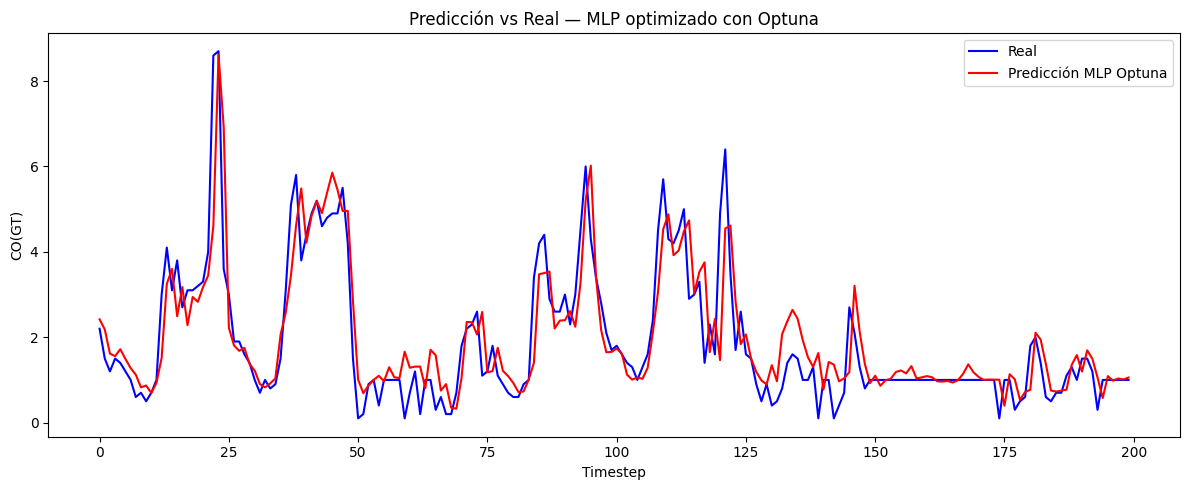

In [46]:
#modelo con los mejores hipermarámetros
params = study.best_params
n_layers = params['n_layers']
units = [params[f'n_units_l{i}'] for i in range(n_layers)]
activation = params['activation']
lr = params['lr']
batch_size = params['batch_size']

# Modelo óptimo
best_model = Sequential()
best_model.add(Dense(units[0], activation=activation, input_shape=(window_size,)))
for u in units[1:]:
    best_model.add(Dense(u, activation=activation))
best_model.add(Dense(1))
best_model.compile(optimizer=Adam(learning_rate=lr), loss='mse')

# Entrenar de nuevo con mejores hiperparámetros
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

best_model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=batch_size,
    callbacks=[early_stop, mlflow_callback],
    verbose=1
)

# Predecir
y_pred = best_model.predict(X_test)

# Invertir escala
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
y_pred_inv = scaler.inverse_transform(y_pred).flatten()

# Gráfica de comparación
import matplotlib.pyplot as plt

n = 200  # mostrar primeros 200 puntos
plt.figure(figsize=(12, 5))
plt.plot(y_test_inv[:n], label='Real', color='blue')
plt.plot(y_pred_inv[:n], label='Predicción MLP Optuna', color='red')
plt.title('Predicción vs Real — MLP optimizado con Optuna')
plt.xlabel('Timestep')
plt.ylabel('CO(GT)')
plt.legend()
plt.tight_layout()
plt.show()


La predicción de este modelo MLP con los mejores hiperparámetros de optuna parece ajustarse muy bien a los datos reales. Sigue de muy buena manera los datos. Obtuvo un r2 de 82.